# Introduction
This notebook is target to train a model to identify if a person is wearing a face mask and a safety helmet.

The dataset is small, with 308 images, and around 1800 detected face.

Target plan as below:
1. Try the basic transfer learning using Resnet-18
2. Leverage YOLO-v5 for the attempt on training with custome data

In [6]:
# Import basic library
import os
import cv2
import random
import numpy as np
from lxml import etree
from tqdm import tqdm
from PIL import Image
import cv2 
from scipy import stats

from IPython.display import display

# Annotation extraction and image chop

In [7]:
IMAGE_SRC = '../dataset/images'
ANNOTATION_FILE = '../dataset/annotations.xml'

img_list = [f for f in os.listdir(IMAGE_SRC) if os.path.isfile(os.path.join(IMAGE_SRC, f))]
root = etree.parse(ANNOTATION_FILE).getroot()

dataset = []

for img_name in img_list:
    img = cv2.imread(os.path.join(IMAGE_SRC, img_name))
    img_id = img_name.split('.')[0]
    image_name_attr = ".//image/[@id='{}']".format(img_id)
    for image_tag in root.iterfind(image_name_attr):
        image = {}
        for key, value in image_tag.items():
            image[key] = value
        for box_tag in image_tag.iter('box'):
            box = {'image_id': img_id, 'img_name': img_name}
            for key, value in box_tag.items():
                box[key] = round(float(value)) if key in ['xbr', 'xtl', 'ybr', 'ytl'] else value
            box['width'] = float(box['xbr']) - float(box['xtl']) 
            box['height'] = float(box['ybr']) - float(box['ytl'])
            box['cropped_image'] = img[ box['ytl']: box['ybr'], box['xtl']:box['xbr']]
            if box['label'] == 'head':
                for attribute_tag in box_tag.iter('attribute'): 
                    if attribute_tag.attrib['name'] == 'has_safety_helmet':
                        box['helmet_label'] = attribute_tag.text
                    if attribute_tag.attrib['name'] == 'mask':
                        box['mask_label'] = attribute_tag.text
                dataset.append(box)


## Select random sample for exploration

In [8]:
def view_sample(data: dict):
    img = cv2.cvtColor( data['cropped_image'], cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))
    print('Helmet: ', data.get('helmet_label', None))
    print('Mask: ', data.get('mask_label', None))
    print('Image Width - Height: {} {}'.format(data['width'], data['height']))

def sample_picker(dataset, sample_id):
    data = dataset[sample_id] 
    view_sample(data)

sample_picker(dataset, sample_id = random.randint(0, len(dataset)))

Helmet:  yes
Mask:  yes
Image Width - Height: 16.0 24.0


# Exploratory Data Analysis

Length of dataset: 1792
Helmet Class distribution: {'yes': 1170, 'no': 622}
Mask Class distribution: {'yes': 494, 'no': 428, 'invisible': 869, 'wrong': 1}


Width DescribeResult(nobs=1792, minmax=(2.0, 1044.0), mean=31.303571428571427, variance=2503.673287070272, skewness=8.227933571175695, kurtosis=116.71127548341272) 

Height DescribeResult(nobs=1792, minmax=(2.0, 1012.0), mean=37.22377232142857, variance=3106.8594457281447, skewness=6.442690011010237, kurtosis=71.04713182089796) 

Ratio DescribeResult(nobs=1792, minmax=(0.5, 3.383177570093458), mean=1.1926839252653214, variance=0.06216621687743987, skewness=1.5830528358306917, kurtosis=9.701898175784155) 

Area DescribeResult(nobs=1792, minmax=(8.0, 1056528.0), mean=3879.4391741071427, variance=859915836.6127135, skewness=27.429987278127957, kurtosis=936.1386429873853) 



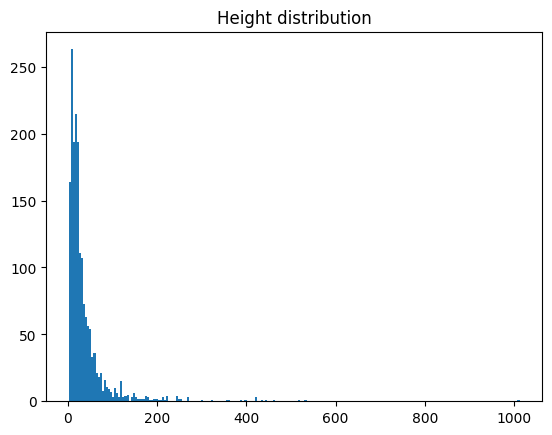

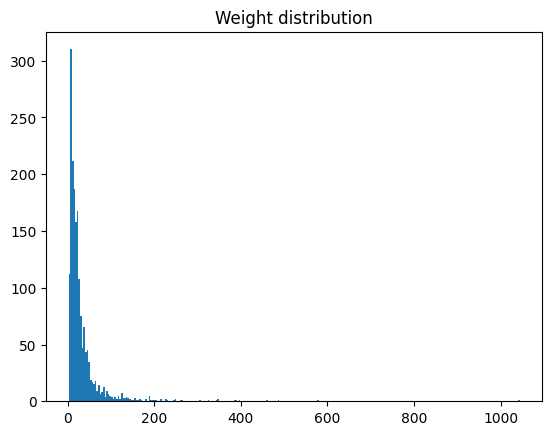

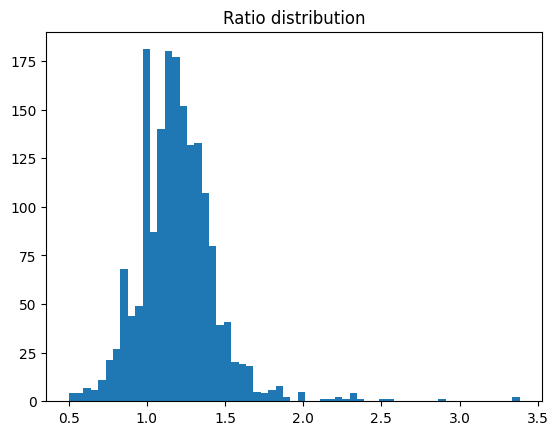

In [9]:
# Length of Dataset
print('Length of dataset: {}'.format(len(dataset)))

# Class distribution
helmet_stat = {}
mask_stat = {}
for data in dataset:
    helmet_stat[data.get('helmet_label', 'None')] = helmet_stat.get(data.get('helmet_label', 'None'), 0) + 1
    mask_stat[data.get('mask_label', 'None')] = mask_stat.get(data.get('mask_label', 'None'), 0) + 1
print('Helmet Class distribution:', helmet_stat)
print('Mask Class distribution:', mask_stat)
print('\n')

# Size distribution
width_list = ([data['width'] for data in dataset])
height_list = ([data['height'] for data in dataset])
hw_scale_list = ([data['height'] /data['width'] for data in dataset])
area_list = ([data['width'] * data['height'] for data in dataset])

print('Width', stats.describe(width_list), "\n")
print('Height', stats.describe(height_list), "\n")
print('Ratio', stats.describe(hw_scale_list), "\n")
print('Area', stats.describe(area_list), "\n")

import matplotlib.pyplot as plt

rng = np.array(height_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Height distribution")
plt.show()

rng = np.array(width_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Weight distribution")
plt.show()


rng = np.array(hw_scale_list)  # deterministic random data
_ = plt.hist(rng, bins='auto')
plt.title("Ratio distribution")
plt.show()

## Special Data
A single  label for "Wrong" Mask 

wrong


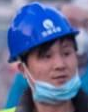

Helmet:  yes
Mask:  wrong
Image Width - Height: 88.0 112.0


In [10]:
special_data = []
for data in dataset:
    if data.get('mask_label', 'None') in [ 'wrong']:
        print(data.get('mask_label', 'None'))
        special_data.append(data)
        view_sample(data)


# Data Cleansing, Transformation, (and Augmentation)

In [28]:
modes = ['train', 'val', 'test']

# For helmet data
PROCESSED_IMAGE_DIR = '..\dataset\processed\helmet'
for data in dataset:
        for mode in modes:
                directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['helmet_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])

# For mask data
PROCESSED_IMAGE_DIR = '..\dataset\processed\mask'
for data in dataset:
        for mode in modes:
                directory = os.path.join(PROCESSED_IMAGE_DIR, mode, data['mask_label'] )
                if not os.path.exists(directory):
                        os.makedirs(directory)
                cv2.imwrite(os.path.join(directory, '{}_{}_{}.jpg'.format(data['image_id'], data['xbr'], data['ybr'])),data['cropped_image'])       

In [12]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [35]:
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [36]:
data_dir = '../dataset/processed/helmet'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

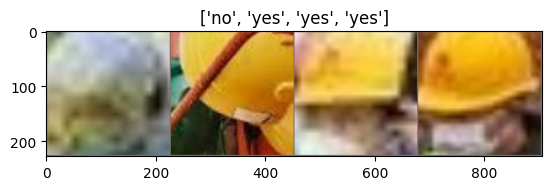

In [38]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Data split (Skip first, by overfit the dataset to prove)

# Model preparation part

# Naiive Model Benchmark

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Transferring Learning from Resnet-18

In [40]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [41]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


C:\ProgramData\Anaconda3\envs\viact\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.6520 Acc: 0.7109
val Loss: 0.4054 Acc: 0.8125

Epoch 1/24
----------
train Loss: 0.6046 Acc: 0.7467
val Loss: 0.3602 Acc: 0.8359

Epoch 2/24
----------
train Loss: 0.5800 Acc: 0.7600
val Loss: 0.3357 Acc: 0.8404

Epoch 3/24
----------
train Loss: 0.5415 Acc: 0.7907
val Loss: 0.2992 Acc: 0.8700

Epoch 4/24
----------
train Loss: 0.4509 Acc: 0.8069
val Loss: 0.2968 Acc: 0.8661

Epoch 5/24
----------
train Loss: 0.4318 Acc: 0.8209
val Loss: 0.3068 Acc: 0.8666

Epoch 6/24
----------
train Loss: 0.4713 Acc: 0.8108
val Loss: 0.2717 Acc: 0.8873

Epoch 7/24
----------
train Loss: 0.3010 Acc: 0.8828
val Loss: 0.2579 Acc: 0.8996

Epoch 8/24
----------
train Loss: 0.3109 Acc: 0.8700
val Loss: 0.2231 Acc: 0.9107

Epoch 9/24
----------
train Loss: 0.3135 Acc: 0.8778
val Loss: 0.2184 Acc: 0.9191

Epoch 10/24
----------
train Loss: 0.3089 Acc: 0.8750
val Loss: 0.2100 Acc: 0.9146

Epoch 11/24
----------
train Loss: 0.2922 Acc: 0.8917
val Loss: 0.2018 Acc: 0.9235

Epoch 12/24
----------
t

# Train Custom Data for YOLO V5
## https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data